In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

In [10]:
df = pd.read_csv('../data/nba.csv')
df.head()

,Unnamed: 0,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,...,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
0,0,Travis Knight,LAL,22.0,213.36,106.59412,Connecticut,USA,1996,1,...,4.8,4.5,0.5,6.2,0.127,0.182,0.142,0.536,0.052,1996-97
1,1,Matt Fish,MIA,27.0,210.82,106.59412,North Carolina-Wilmington,USA,1992,2,...,0.3,0.8,0.0,-15.1,0.143,0.267,0.265,0.333,0.000,1996-97
2,2,Matt Bullard,HOU,30.0,208.28,106.59412,Iowa,USA,Undrafted,Undrafted,...,4.5,1.6,0.9,0.9,0.016,0.115,0.151,0.535,0.099,1996-97
3,3,Marty Conlon,BOS,29.0,210.82,111.13004,Providence,USA,Undrafted,Undrafted,...,7.8,4.4,1.4,-9.0,0.083,0.152,0.167,0.542,0.101,1996-97
4,4,Martin Muursepp,DAL,22.0,205.74,106.59412,None,USA,1996,1,...,3.7,1.6,0.5,-14.5,0.109,0.118,0.233,0.482,0.114,1996-97


In [11]:
len(df)

11700

In [12]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [6]:
def preprocess_data(df):
    
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                df[label] = content.fillna(content.median())
    
    for label, content in df.items():
        if not pd.api.types.is_numeric_dtype(content):
            df[label] = pd.Categorical(content).codes+1
    
    return df

In [7]:
df_tmp = preprocess_data(df)
df_tmp.head()

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,...,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
0,2170,15,22.0,213.36,106.59412,62,73,21,2,29,...,4.8,4.5,0.5,6.2,0.127,0.182,0.142,0.536,0.052,1
1,1545,17,27.0,210.82,106.59412,190,73,17,3,53,...,0.3,0.8,0.0,-15.1,0.143,0.267,0.265,0.333,0.000,1
2,1542,12,30.0,208.28,106.59412,115,73,46,9,76,...,4.5,1.6,0.9,0.9,0.016,0.115,0.151,0.535,0.099,1
3,1532,3,29.0,210.82,111.13004,221,73,46,9,76,...,7.8,4.4,1.4,-9.0,0.083,0.152,0.167,0.542,0.101,1
4,1531,8,22.0,205.74,106.59412,185,73,21,2,25,...,3.7,1.6,0.5,-14.5,0.109,0.118,0.233,0.482,0.114,1


In [13]:
df_2010_2020 = df['2010-11'<= df.season]
df_2010_2020 = df_2010_2020[df_2010_2020.season <= '2019-2020']
df_valid = preprocess_data(df_2010_2020)

In [14]:
df_1996_2010 = df[df.season < '2010-11']
df_train = preprocess_data(df_1996_2010)

C:\Users\Asus\AppData\Local\Temp/ipykernel_12136/1326615646.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label] = pd.Categorical(content).codes+1


In [15]:
df_2020_2021 = df[df.season == '2020-21']
df_test = preprocess_data(df_2020_2021)

C:\Users\Asus\AppData\Local\Temp/ipykernel_12136/1326615646.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label] = pd.Categorical(content).codes+1


In [16]:
model = RandomForestRegressor(n_jobs=-1, random_state=23).fit(df_tmp.drop('ast', axis=1), df_tmp['ast'])

In [17]:
model.score(df_tmp.drop('ast', axis=1), df_tmp['ast'])

0.9970609762605984

In [18]:
X_train, y_train = df_train.drop('ast', axis=1), df_train['ast']
X_val, y_val = df_valid.drop('ast', axis=1), df_valid['ast']
X_test, y_test = df_test.drop('ast', axis=1), df_test['ast']

In [100]:
from sklearn.model_selection import RandomizedSearchCV
rf_grid = {
    'n_estimators':np.arange(100, 1000, 100),
    'max_depth':[None, 3, 5],
    'max_features':['auto', 'sqrt', 'log2'],
    'min_samples_split':np.arange(2, 20, 2),
    'min_samples_leaf':np.arange(1, 20, 2)
}

rs_model = RandomizedSearchCV(RandomForestRegressor(),
                             param_distributions=rf_grid,
                             n_iter=20,
                             cv=5,
                             verbose=True)
%time rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Wall time: 3min 13s


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([100, 200, 300, 400, 500, 600, 700, 800, 900])},
                   verbose=True)

In [101]:
rs_model.best_params_

{'n_estimators': 400,
 'min_samples_split': 10,
 'min_samples_leaf': 3,
 'max_features': 'auto',
 'max_depth': None}

In [19]:
ideal_model = RandomForestRegressor(n_estimators=800,
                                   min_samples_split=2,
                                   min_samples_leaf=1,
                                   max_features='auto',
                                   max_depth=None)
ideal_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=800)

In [20]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_log_error

def rmsle(y_true, y_preds):
    return np.sqrt(mean_squared_log_error(y_true, y_preds))

def show_scores(model):
    train_preds = model.predict(X_train)
    valid_preds = model.predict(X_val)
    
    scores = {
        'Training MAE':mean_absolute_error(y_train, train_preds),
        'Valid MAE':mean_absolute_error(y_val, valid_preds),
        'Training RMSLE':rmsle(y_train, train_preds),
        'Valid RMSLE':rmsle(y_val, valid_preds),
        'Training R2':r2_score(y_train, train_preds),
        'Valid R2':r2_score(y_val, valid_preds)
    }
    
    return scores

In [21]:
show_scores(ideal_model), show_scores(model)

({'Training MAE': 0.05791135962094418,
  'Valid MAE': 0.17566877786785576,
  'Training RMSLE': 0.026812932858173856,
  'Valid RMSLE': 0.07891912227932203,
  'Training R2': 0.9969730328322338,
  'Valid R2': 0.9708891383882133},
 {'Training MAE': 0.06583344041117895,
  'Valid MAE': 0.08224827725982979,
  'Training RMSLE': 0.02994730705652624,
  'Valid RMSLE': 0.038096137817745304,
  'Training R2': 0.9960254236492785,
  'Valid R2': 0.9929082716540245})

In [22]:
test_preds = ideal_model.predict(X_test)

In [23]:
test_preds.mean(), df.ast.mean()

(1.9785120370370368, 1.8111794871794906)

In [24]:
df = pd.read_csv('../data/nba.csv')
df_2020_2021 = df[df.season == '2020-21']
df_preds = pd.DataFrame()
df_preds['Player_Name'] = df_2020_2021.player_name
df_preds['Assists'] = test_preds
df_preds

,Player_Name,Assists
11160,Yogi Ferrell,2.421375
11161,Zion Williamson,3.878375
11162,Zeke Nnaji,0.261625
11163,Zach LaVine,4.639875
11164,Yuta Watanabe,1.028625
...,...,...
11695,Matthew Dellavedova,2.797125
11696,Maurice Harkless,1.074750
11697,Max Strus,0.786375
11698,Marcus Morris Sr.,1.115500


In [25]:
df_preds.to_csv("../prediction\'s/2020-21-APG-Prediction.csv")

In [26]:
def plot_feature_importance(col, importance, n=20):
    df = pd.DataFrame({'features':col,
                 'feature_importance':importance}).sort_values('feature_importance', ascending=False)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(df['features'][:20], df['feature_importance'][:20], color='hotpink')
    ax.invert_yaxis()
    ax.set_xlabel('Importance')
    ax.set_ylabel('Features')
    ax.set_title('Feature Importances')

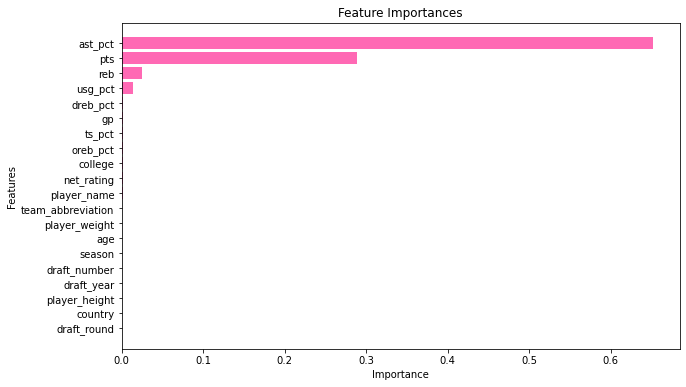

In [27]:
plot_feature_importance(X_train.columns, ideal_model.feature_importances_)